In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/symptoms-to-diseases/symptom_to_disease_negated.xlsx
/kaggle/input/symptoms-to-diseases/symptoms_to_disease.xlsx
/kaggle/input/symptoms-to-diseases/final_symptoms_to_disease.csv
/kaggle/input/symptoms-to-diseases/data.csv
/kaggle/input/symptoms-to-diseases/symptoms_to_disease_augmented.xlsx


### Final Aproach

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.nn import CrossEntropyLoss
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

2025-11-08 05:26:13.678377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762579573.850907      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762579573.899775      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df=pd.read_csv("/kaggle/input/symptoms-to-diseases/data.csv")

In [4]:
df.shape

(246945, 378)

In [5]:
df.head(5)

,diseases,anxiety_and_nervousness,depression,shortness_of_breath,depressive_or_psychotic_symptoms,sharp_chest_pain,dizziness,insomnia,abnormal_involuntary_movements,chest_tightness,...,stuttering_or_stammering,problems_with_orgasm,nose_deformity,lump_over_jaw,sore_in_nose,hip_weakness,back_swelling,ankle_stiffness_or_tightness,ankle_weakness,neck_weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.columns

Index(['diseases', 'anxiety_and_nervousness', 'depression',
       'shortness_of_breath', 'depressive_or_psychotic_symptoms',
       'sharp_chest_pain', 'dizziness', 'insomnia',
       'abnormal_involuntary_movements', 'chest_tightness',
       ...
       'stuttering_or_stammering', 'problems_with_orgasm', 'nose_deformity',
       'lump_over_jaw', 'sore_in_nose', 'hip_weakness', 'back_swelling',
       'ankle_stiffness_or_tightness', 'ankle_weakness', 'neck_weakness'],
      dtype='object', length=378)

### Preprocessing Part

In [7]:
# Rename all symptom columns by replacing '_' with ' '
df.rename(columns=lambda c: c.replace('_', ' '), inplace=True)

In [8]:
df.columns

Index(['diseases', 'anxiety and nervousness', 'depression',
       'shortness of breath', 'depressive or psychotic symptoms',
       'sharp chest pain', 'dizziness', 'insomnia',
       'abnormal involuntary movements', 'chest tightness',
       ...
       'stuttering or stammering', 'problems with orgasm', 'nose deformity',
       'lump over jaw', 'sore in nose', 'hip weakness', 'back swelling',
       'ankle stiffness or tightness', 'ankle weakness', 'neck weakness'],
      dtype='object', length=378)

In [9]:
df.head(5)

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Identify symptom columns (assuming 'Disease' is the label)
symptom_cols = [col for col in df.columns if col.lower() != 'diseases']

# Convert binary symptoms into text
def binary_to_text(row):
    return ', '.join([symptom for symptom in symptom_cols if row[symptom] == 1])

# Apply conversion
df['symptom_text'] = df.apply(binary_to_text, axis=1)

# Create a new DataFrame with only required columns
final_df = df[['diseases', 'symptom_text']].copy()

print("✅ New dataset created and saved successfully!")
print("Shape:", final_df.shape)
print(final_df.head())


✅ New dataset created and saved successfully!
Shape: (246945, 2)
         diseases                                       symptom_text
0  panic disorder  anxiety and nervousness, shortness of breath, ...
1  panic disorder  shortness of breath, depressive or psychotic s...
2  panic disorder  anxiety and nervousness, depression, shortness...
3  panic disorder  anxiety and nervousness, depressive or psychot...
4  panic disorder  anxiety and nervousness, depression, insomnia,...


In [11]:
final_df.head(5)

,diseases,symptom_text
0,panic disorder,"anxiety and nervousness, shortness of breath, ..."
1,panic disorder,"shortness of breath, depressive or psychotic s..."
2,panic disorder,"anxiety and nervousness, depression, shortness..."
3,panic disorder,"anxiety and nervousness, depressive or psychot..."
4,panic disorder,"anxiety and nervousness, depression, insomnia,..."


In [12]:
final_df.shape

(246945, 2)

In [13]:
# Count how many samples each disease has
disease_counts = final_df['diseases'].value_counts()

# Find diseases with less than 50 samples
rare_diseases = disease_counts[disease_counts > 400]

print(f"Number of diseases with >100 samples: {len(rare_diseases)}")
print("Examples:\n", rare_diseases.head(10))


Number of diseases with >100 samples: 254
Examples:
 diseases
cystitis                          1219
nose disorder                     1218
vulvodynia                        1218
complex regional pain syndrome    1217
spondylosis                       1216
hypoglycemia                      1215
vaginal cyst                      1215
peripheral nerve disorder         1215
conjunctivitis due to allergy     1215
esophagitis                       1215
Name: count, dtype: int64


In [14]:
# Keep only diseases with ≥50 samples
valid_diseases = disease_counts[disease_counts >= 400].index

cleaned_df = final_df[final_df['diseases'].isin(valid_diseases)].reset_index(drop=True)

print("Shape after cleaning:", cleaned_df.shape)


Shape after cleaning: (192715, 2)


In [15]:
output_path = '/kaggle/working/final_symptoms_to_disease.csv'
cleaned_df.to_csv(output_path, index=False)

In [16]:
cleaned_df.head(5)

,diseases,symptom_text
0,panic disorder,"anxiety and nervousness, shortness of breath, ..."
1,panic disorder,"shortness of breath, depressive or psychotic s..."
2,panic disorder,"anxiety and nervousness, depression, shortness..."
3,panic disorder,"anxiety and nervousness, depressive or psychot..."
4,panic disorder,"anxiety and nervousness, depression, insomnia,..."


In [17]:
import os
from IPython.display import FileLink

file_to_download = "final_symptoms_to_disease.csv"

if os.path.exists(file_to_download):
    print("✅ File is ready for download.")
    print("Click the link below to start the download to your computer:")
    
    display(FileLink(file_to_download))

else:
    print(f"❌ Error: The file '{file_to_download}' was not found.")
    print("Please make sure you have run the '!zip' command in the previous cell to create the file first.")

✅ File is ready for download.
Click the link below to start the download to your computer:


/kaggle/working/final_symptoms_to_disease.csv

### Model Training Part

In [4]:
df=pd.read_csv("/kaggle/input/symptoms-to-diseases/final_symptoms_to_disease.csv")

In [5]:
df.shape

(192715, 2)

In [6]:
df.nunique()

diseases           254
symptom_text    149241
dtype: int64

In [7]:
df.head(5)

,diseases,symptom_text
0,panic disorder,"anxiety and nervousness, shortness of breath, ..."
1,panic disorder,"shortness of breath, depressive or psychotic s..."
2,panic disorder,"anxiety and nervousness, depression, shortness..."
3,panic disorder,"anxiety and nervousness, depressive or psychot..."
4,panic disorder,"anxiety and nervousness, depression, insomnia,..."


In [8]:
texts = df["symptom_text"].astype(str).tolist()
labels = df["diseases"].astype("category")
df["label"] = labels.cat.codes   # numeric labels
id2label = dict(enumerate(labels.cat.categories))
label2id = {v: k for k, v in id2label.items()}

In [9]:
# ----------------------
# 2. Stratified Split
# ----------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# ----------------------
# 3. Convert to HF Dataset
# ----------------------
train_dataset = Dataset.from_pandas(train_df[["symptom_text", "label"]])
test_dataset = Dataset.from_pandas(test_df[["symptom_text", "label"]])
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

In [10]:
# ----------------------
# 4. Tokenizer
# ----------------------
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["symptom_text"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# ----------------------
# 5. Model
# ----------------------
num_labels = len(id2label)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/154172 [00:00<?, ? examples/s]

Map:   0%|          | 0/38543 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# ----------------------
# 6. Compute Metrics
# ----------------------
def compute_metrics(eval_pred):
    """
    Computes multiple metrics: accuracy, weighted F1, macro F1,
    precision, recall for better model evaluation.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1_weighted = f1_score(labels, preds, average="weighted")
    f1_macro = f1_score(labels, preds, average="macro")
    prec = precision_score(labels, preds, average="weighted", zero_division=0)
    rec = recall_score(labels, preds, average="weighted", zero_division=0)
    return {
        "accuracy": acc,
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro,
        "precision": prec,
        "recall": rec,
    }

# ----------------------
# 7. Handle Class Imbalance with Weights
# ----------------------
# Create weights inversely proportional to class frequency
class_counts = train_df["label"].value_counts().to_dict()
weights = [1.0 / class_counts.get(i, 1) for i in range(num_labels)]
weights = torch.tensor(weights).to(torch.float32)

# Custom Trainer class that uses weighted loss and tracks train accuracy
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        # Track training accuracy on-the-fly (optional)
        preds = torch.argmax(logits, dim=-1)
        train_acc = (preds == labels).float().mean().item()

        # Log training accuracy to the progress bar
        if model.training and hasattr(self, "state") and self.state:
            self.log({"train_accuracy": train_acc})

        return (loss, outputs) if return_outputs else loss


In [13]:
import wandb
from kaggle_secrets import UserSecretsClient

# Get the API key from Kaggle Secrets
user_secrets = UserSecretsClient()
WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")

# Log in to W&B
wandb.login(key=WANDB_API_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bt23csa007 (bt23csa007-iiit-nagpur-official) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [14]:
# ----------------------
# 8. Training Args (with checkpoint saving)
# ----------------------
import datetime
from transformers import EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)
run_name = f"biobert-finetune-{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

training_args = TrainingArguments(
    output_dir=f"./results/{run_name}",
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    run_name=run_name,
    overwrite_output_dir=True,
    lr_scheduler_type="linear",
    weight_decay=0.01,
    # report_to="none",
    save_total_limit=2,          # keep only 2 checkpoints
    load_best_model_at_end=True, # load best checkpoint
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    warmup_steps=500,
    logging_dir="./logs",
    logging_steps=50
)
# ----------------------
# 9. Trainer
# ----------------------
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    # tokenizer=tokenizer,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,0.516400,0.422815,0.853021,0.855826,0.858579,0.876167,0.853021
2,0.400700,0.376562,0.859066,0.860554,0.863426,0.876185,0.859066
3,0.380200,0.367646,0.859949,0.861264,0.864586,0.878132,0.859949
4,0.385000,0.352867,0.858989,0.859700,0.863955,0.874629,0.858989
5,0.301300,0.352068,0.864359,0.866508,0.870289,0.880307,0.864359
6,0.304500,0.347099,0.862647,0.863274,0.867118,0.875954,0.862647
7,0.339700,0.344557,0.862984,0.863758,0.867402,0.877499,0.862984


TrainOutput(global_step=67452, training_loss=0.45807889916681455, metrics={'train_runtime': 14552.2342, 'train_samples_per_second': 211.888, 'train_steps_per_second': 13.243, 'total_flos': 7.11482428978729e+16, 'train_loss': 0.45807889916681455, 'epoch': 7.0})

### Save Model

In [16]:
# 11. SAVE THE FINAL MODEL
print("✅ Training complete. Saving the best model...")

final_model_path = "./final-model"

trainer.save_model(final_model_path)

tokenizer.save_pretrained(final_model_path)

print(f"Model saved to {final_model_path}. You can now download it from the 'Output' section.")

# Zip the folder

!zip -r final-model.zip final-model

✅ Training complete. Saving the best model...
Model saved to ./final-model. You can now download it from the 'Output' section.
  adding: final-model/ (stored 0%)
  adding: final-model/config.json (deflated 71%)
  adding: final-model/tokenizer_config.json (deflated 74%)
  adding: final-model/tokenizer.json (deflated 70%)
  adding: final-model/vocab.txt (deflated 49%)
  adding: final-model/training_args.bin (deflated 52%)
  adding: final-model/special_tokens_map.json (deflated 42%)
  adding: final-model/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)


In [17]:
import os
from IPython.display import FileLink

file_to_download = "final-model.zip"

if os.path.exists(file_to_download):
    print("✅ File is ready for download.")
    print("Click the link below to start the download to your computer:")
    
    display(FileLink(file_to_download))

else:
    print(f"❌ Error: The file '{file_to_download}' was not found.")
    print("Please make sure you have run the '!zip' command in the previous cell to create the file first.")

✅ File is ready for download.
Click the link below to start the download to your computer:


/kaggle/working/final-model.zip

### Important Plots

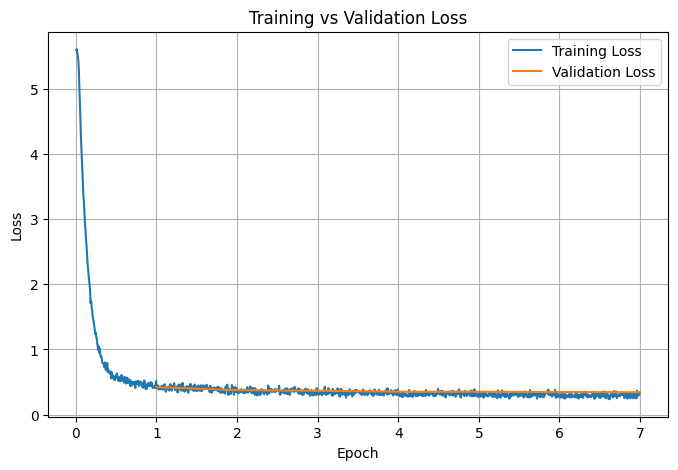

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training logs from the Trainer's log_history
log_history = pd.DataFrame(trainer.state.log_history)

# Keep only loss-related entries
loss_df = log_history[log_history["loss"].notna()][["epoch", "loss"]]
eval_loss_df = log_history[log_history["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(8, 5))
plt.plot(loss_df["epoch"], loss_df["loss"], label="Training Loss")
plt.plot(eval_loss_df["epoch"], eval_loss_df["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

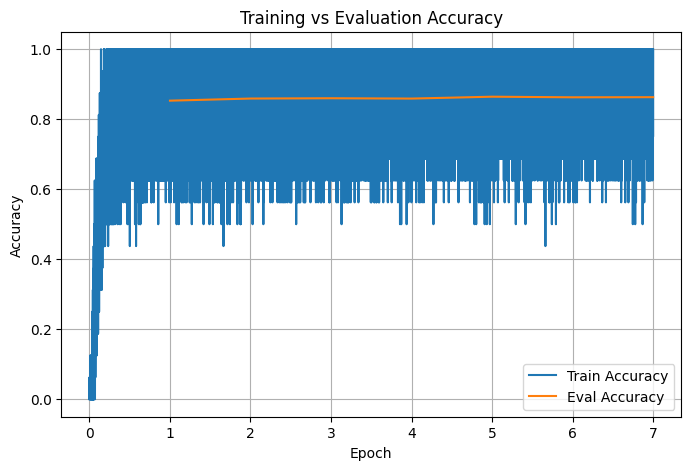

In [20]:
train_acc = log_history[log_history["train_accuracy"].notna()][["epoch", "train_accuracy"]]
eval_acc = log_history[log_history["eval_accuracy"].notna()][["epoch", "eval_accuracy"]]

plt.figure(figsize=(8,5))
plt.plot(train_acc["epoch"], train_acc["train_accuracy"], label="Train Accuracy")
plt.plot(eval_acc["epoch"], eval_acc["eval_accuracy"], label="Eval Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Evaluation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

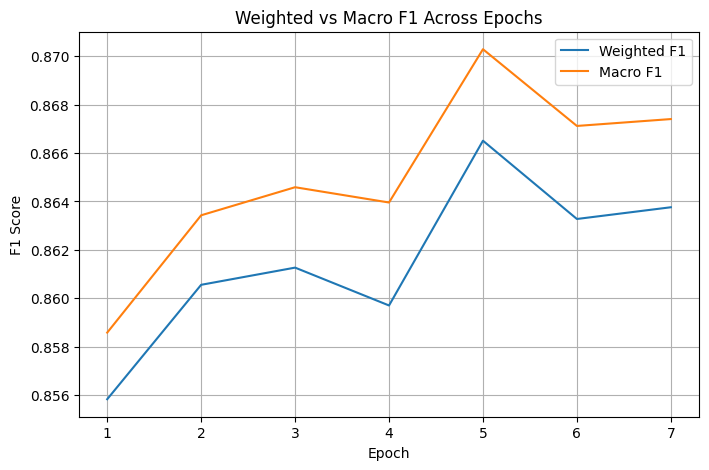

In [21]:
f1_weighted = log_history[log_history["eval_f1_weighted"].notna()][["epoch", "eval_f1_weighted"]]
f1_macro = log_history[log_history["eval_f1_macro"].notna()][["epoch", "eval_f1_macro"]]

plt.figure(figsize=(8,5))
plt.plot(f1_weighted["epoch"], f1_weighted["eval_f1_weighted"], label="Weighted F1")
plt.plot(f1_macro["epoch"], f1_macro["eval_f1_macro"], label="Macro F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Weighted vs Macro F1 Across Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
import pandas as pd


# Evaluate best model on test set

final_metrics = trainer.evaluate()
print("✅ Final Test Metrics:\n")
for k, v in final_metrics.items():
    print(f"{k}: {v:.4f}")

metrics_path = "/kaggle/working/final_test_metrics.csv"
pd.DataFrame([final_metrics]).to_csv(metrics_path, index=False)
print(f"\n📁 Metrics saved to: {metrics_path}")

!zip -r final_test_metrics.zip /kaggle/working/final_test_metrics.csv

✅ Final Test Metrics:

eval_loss: 0.3521
eval_accuracy: 0.8644
eval_f1_weighted: 0.8665
eval_f1_macro: 0.8703
eval_precision: 0.8803
eval_recall: 0.8644
eval_runtime: 139.3649
eval_samples_per_second: 276.5620
eval_steps_per_second: 17.2860
epoch: 7.0000

📁 Metrics saved to: /kaggle/working/final_test_metrics.csv
  adding: kaggle/working/final_test_metrics.csv (deflated 40%)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# -----------------------------
# 1️⃣ Get true labels and predictions
# -----------------------------
print("Generating predictions on test set...")

preds_output = trainer.predict(dataset["test"])
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

print("✅ Predictions completed.")

# -----------------------------
# 2️⃣ Compute confusion matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
num_labels = len(model.config.id2label)

print(f"Confusion matrix shape: {cm.shape} ({num_labels} x {num_labels})")

# Convert label IDs to names for better readability
labels = [model.config.id2label[i] for i in range(num_labels)]

Generating predictions on test set...
✅ Predictions completed.
Confusion matrix shape: (254, 254) (254 x 254)


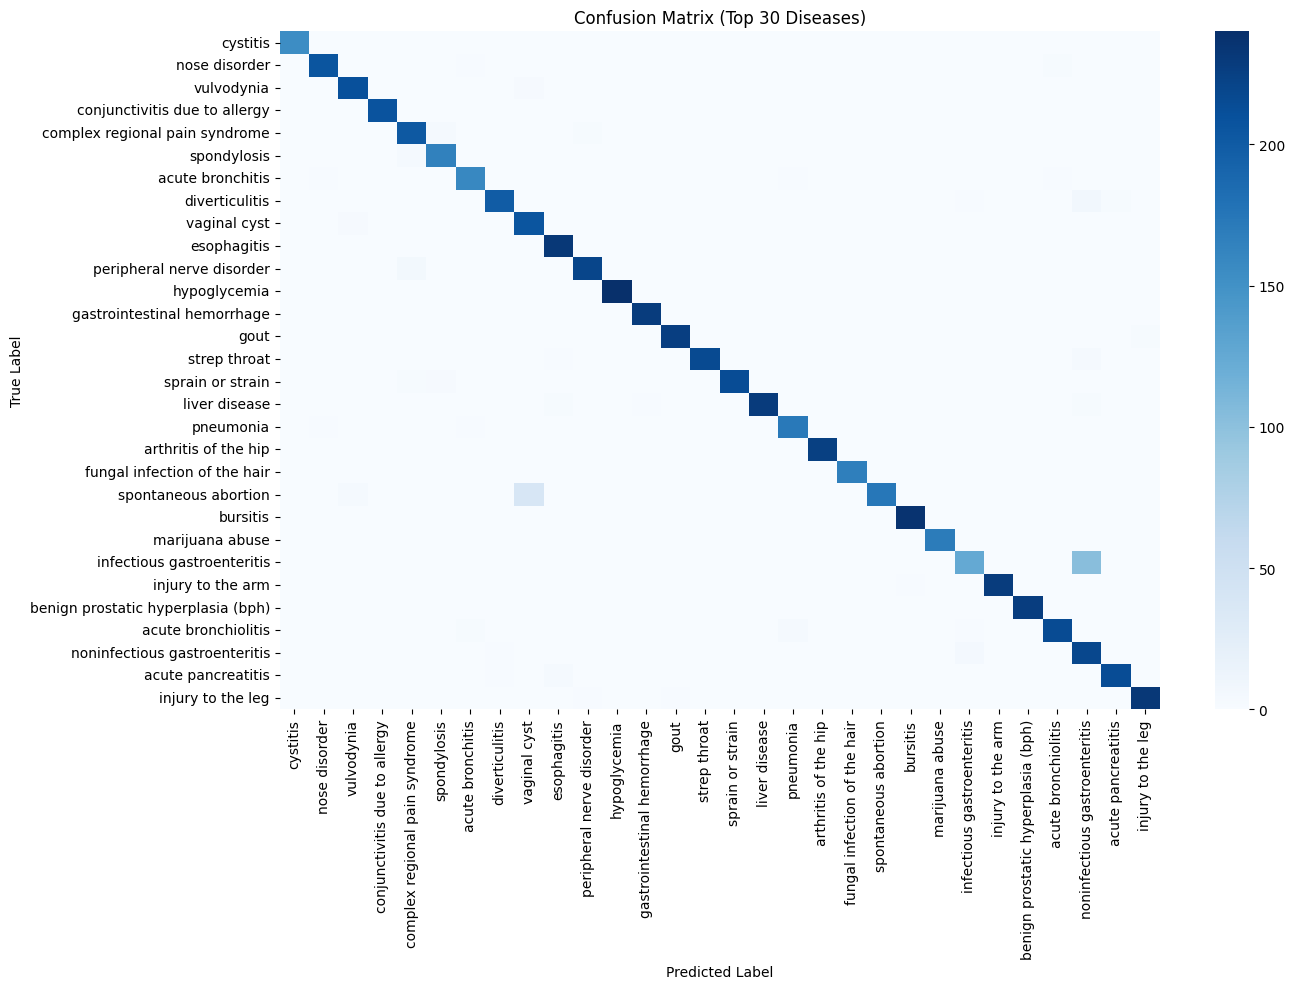

✅ Heatmap saved at: /kaggle/working/confusion_matrix_heatmap.png


In [25]:
import seaborn as sns

# -----------------------------
# 3️⃣ Plot heatmap (top 30 classes for readability)
# -----------------------------
plt.figure(figsize=(14, 10))

# Select top 30 diseases with most samples for visualization
test_df = pd.DataFrame({"true": y_true, "pred": y_pred})
top_labels = (
    test_df["true"]
    .value_counts()
    .head(30)
    .index.tolist()
)
top_label_names = [model.config.id2label[i] for i in top_labels]

# Subset the confusion matrix
cm_subset = cm[np.ix_(top_labels, top_labels)]

sns.heatmap(
    cm_subset,
    cmap="Blues",
    annot=False,
    fmt="d",
    xticklabels=top_label_names,
    yticklabels=top_label_names
)

plt.title("Confusion Matrix (Top 30 Diseases)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# -----------------------------
# 4️⃣ Save and display
# -----------------------------
heatmap_path = "/kaggle/working/confusion_matrix_heatmap.png"
plt.savefig(heatmap_path, dpi=300)
plt.show()

print(f"✅ Heatmap saved at: {heatmap_path}")


### Prediction Part

In [28]:
# ----------------------
# 11. Prediction function (top 3 diseases)
# ----------------------
def predict_disease(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1).detach().cpu().numpy()[0]
    top3_idx = probs.argsort()[-3:][::-1]
    top3_diseases = [id2label[i] for i in top3_idx]
    top3_probs = [probs[i] for i in top3_idx]
    return list(zip(top3_diseases, top3_probs))

In [41]:
symptom_text = "hoarseness or a complete loss of voice, a sore or scratchy throat, a dry cough, and a constant urge to clear your throat"
print(predict_disease(symptom_text))

[('laryngitis', 0.79402596), ('croup', 0.04749906), ('nose disorder', 0.029957281)]


In [34]:
df[df["diseases"]=="breast cancer"]

,diseases,symptom_text,label


In [31]:
df["symptom_text"][1520]

'suprapubic pain, vaginal itching, lower abdominal pain, pain during pregnancy, vaginal pain'

In [42]:
from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)
df.head()

,diseases,symptom_text,label
0,post-traumatic stress disorder (ptsd),"depression, hostile behavior, drug abuse",191
1,tonsillitis,"sore throat, nasal congestion, diminished hear...",236
2,acute respiratory distress syndrome (ards),"shortness of breath, sharp chest pain, chest t...",9
3,idiopathic absence of menstruation,"sharp abdominal pain, vaginal itching, heartbu...",126
4,tooth disorder,"headache, mouth ulcer, peripheral edema, jaw s...",238


In [43]:
def predict_disease(text):
    print(f"\nOriginal user input: '{text}'")
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(model.device)
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1).detach().cpu().numpy()[0]
    top3_idx = probs.argsort()[-3:][::-1]
    top3_diseases = [id2label[i] for i in top3_idx]
    top3_probs = [probs[i] for i in top3_idx]
    return list(zip(top3_diseases, top3_probs))

In [45]:
def run_test_cases():
	"""
	Run predictions predict_disease (defined in notebook),
	and calculate Top-1 and Top-3 accuracy.
	"""
	top1_correct = 0
	top3_correct = 0
	total = 100

	for i in range(1, total+1):
		symptoms=df["symptom_text"][i-1]
		expected=df["diseases"][i-1] 
		try:
			preds = predict_disease(symptoms)  # returns list of (disease, prob)
			if not preds:
				print(f"❌ {i}. {expected}: no predictions")
				continue

			top1 = preds[0][0].lower()
			top3 = [p[0].lower() for p in preds]
			expected_lower = expected.lower()

			is_top1 = expected_lower in top1 or top1 in expected_lower
			is_top3 = any(expected_lower in d or d in expected_lower for d in top3)

			if is_top1:
				top1_correct += 1
				top3_correct += 1
				print(f"✅ {i}. {expected}: TOP-1 -> {preds[0][0]}")
			elif is_top3:
				top3_correct += 1
				print(f"⚠️  {i}. {expected}: in TOP-3 -> {top3}")
			else:
				print(f"❌ {i}. {expected}: TOP-1 -> {preds[0][0]} | TOP-3 -> {top3}")

		except Exception as e:
			print(f"❌ {i}. {expected}: Error -> {e}")

	top1_acc = (top1_correct / total) * 100 if total else 0.0
	top3_acc = (top3_correct / total) * 100 if total else 0.0

	print("\n" + "="*40)
	print(f"RESULTS: Total={total}")
	print(f"Top-1 Accuracy: {top1_acc:.2f}% ({top1_correct}/{total})")
	print(f"Top-3 Accuracy: {top3_acc:.2f}% ({top3_correct}/{total})")
	print("="*40)

	return top1_acc, top3_acc

run_test_cases()


Original user input: 'depression, hostile behavior, drug abuse'
✅ 1. post-traumatic stress disorder (ptsd): TOP-1 -> post-traumatic stress disorder (ptsd)

Original user input: 'sore throat, nasal congestion, diminished hearing, lump in throat, throat feels tight, abnormal breathing sounds, throat redness'
✅ 2. tonsillitis: TOP-1 -> tonsillitis

Original user input: 'shortness of breath, sharp chest pain, chest tightness'
❌ 3. acute respiratory distress syndrome (ards): TOP-1 -> pulmonary congestion | TOP-3 -> ['pulmonary congestion', 'sinus bradycardia', 'angina']

Original user input: 'sharp abdominal pain, vaginal itching, heartburn, pain or soreness of breast, absence of menstruation, long menstrual periods'
✅ 4. idiopathic absence of menstruation: TOP-1 -> idiopathic absence of menstruation

Original user input: 'headache, mouth ulcer, peripheral edema, jaw swelling, pain in gums'
✅ 5. tooth disorder: TOP-1 -> tooth disorder

Original user input: 'diminished hearing, vomiting, he

(84.0, 97.0)

In [36]:
df["diseases"].unique()

array(['panic disorder', 'eye alignment disorder', 'vaginitis',
       'glaucoma', 'eating disorder', 'transient ischemic attack',
       'pyelonephritis', 'chronic pain disorder',
       'problem during pregnancy', 'choledocholithiasis',
       'diabetic retinopathy', 'fibromyalgia', 'acute pancreatitis',
       'thrombophlebitis', 'asthma', 'teething syndrome',
       'infectious gastroenteritis', 'acute sinusitis',
       'postpartum depression', 'spondylitis', 'uterine fibroids',
       'chalazion', 'vaginal yeast infection', 'ingrown toe nail',
       'corneal disorder', 'viral warts', 'stroke',
       'pelvic organ prolapse', 'fracture of the arm', 'hyperkalemia',
       'cornea infection', 'chronic sinusitis', 'conductive hearing loss',
       'abdominal hernia', 'marijuana abuse', 'indigestion', 'bursitis',
       'pulmonary congestion', 'actinic keratosis', 'acute otitis media',
       'chronic obstructive pulmonary disease (copd)', 'spondylosis',
       'herpangina', 'injury 